## Python Windrose with MesoWest Data

You'll need the windrose package. The original code is found here: https://github.com/scls19fr/windrose.  
I provided the `pm25rose.py` script. Make sure that is in you current directory.  
(How is `pm25rose.py` different from `windrose.py`, you ask? Just some lines where the legend units are defined)

#### Import some stuff we'll use

In [270]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime
import json
import urllib2

# Confirm that `pm25rose.py` is in your directory
from pm25rose import WindroseAxes

 #### Customize matplotlib 
 It's so much easier to modify matplotlib defaults like this rather than inline with the plot functions.  
 See more here [http://matplotlib.org/users/customizing.html](http://matplotlib.org/users/customizing.html)

In [271]:
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = [5, 10]
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100           # set to 72 or 100 for web, 300 for print

### Define a few functions

In [272]:
# String of some MesoWest variables available from this list:
# https://synopticlabs.org/api/mesonet/variables/
default_vars = 'altimeter,pressure,sea_level_pressure,wind_direction,\
wind_speed,air_temp,relative_humidity,dew_point_temperature,wind_gust'

def get_mesowest_ts(stationID, start_time, end_time, variables = default_vars):
    """
    Get MesoWest Time Series:
    Makes a time series query from the MesoWest API for a single station.

    Input:
        stationID  : string of the station ID
        start_time : datetime object of the start time in UTC
        end_time   : datetime object of the end time in UTC
        variables  : a string of variables available through the MesoWest API

    Output:
        A dictionary of the data.
    """

    # Hey! Get your own token! https://synopticlabs.org/api/guides/?getstarted
    token = '1234567890'
    
    # Convert the start and end time to the string format requried by the API
    start = start_time.strftime("%Y%m%d%H%M")
    end = end_time.strftime("%Y%m%d%H%M")
    tz = 'utc'  # This is hard coded for now. Local time could be added later.

    # The API request URL
    URL = 'http://api.mesowest.net/v2/stations/timeseries?&token=' + token \
        + '&stid=' + stationID \
        + '&start=' + start \
        + '&end=' + end \
        + '&vars=' + variables \
        + '&obtimezone=' + tz \
        + '&output=json'

    print "Here is the URL you wanted:", URL
        
    # Open URL and read JSON content. Convert JSON string to some python
    # readable format.
    f = urllib2.urlopen(URL)
    data = f.read()
    data = json.loads(data)

    # Store the data we will return in this new dictionary
    return_this = {}

    # Get basic station information
    return_this['URL'] = URL
    return_this['NAME'] = str(data['STATION'][0]['NAME'])
    return_this['STID'] = str(data['STATION'][0]['STID'])
    return_this['LAT'] = float(data['STATION'][0]['LATITUDE'])
    return_this['LON'] = float(data['STATION'][0]['LONGITUDE'])
    return_this['ELEVATION'] = float(data['STATION'][0]['ELEVATION'])
                                  # Note: Elevation is in feet, NOT METERS!


    # Dynamically create keys in the dictionary for each requested variable
    for v in data['STATION'][0]['SENSOR_VARIABLES'].keys():
        if v == 'date_time':
            # Dates: Convert the strings to a python datetime object.mro
            dates = data["STATION"][0]["OBSERVATIONS"]["date_time"]
            DATES = [datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ') for x in dates]
            return_this['DATETIME'] = np.array(DATES)

        else:
            # v represents all the variables, but each variable may have
            # more than one set.
            # For now, just return the first set.
            key_name = str(v)
            set_num = 0

            grab_this_set = str(data['STATION'][0]['SENSOR_VARIABLES']\
                                [key_name].keys()[set_num])

            # Always grab the first set (either _1 or _1d)
            # !should make exceptions to this rule for certain stations and certain variables (a project for another day).
            if grab_this_set[-1] != '1' and grab_this_set[-1] != 'd':
                grab_this_set = grab_this_set[0:-1]+'1'
            if grab_this_set[-1] == 'd':
                grab_this_set = grab_this_set[0:-2]+'1d'

            variable_data = np.array(data['STATION'][0]['OBSERVATIONS']\
                                    [grab_this_set], dtype=np.float)
            return_this[key_name] = variable_data

    return return_this

In [273]:
# Make Rose
#A quick way to create new windrose axes...
def new_axes():
    fig = plt.figure(facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect, axisbg='w')
    fig.add_axes(ax)
    return ax
#...and adjust the legend box
def set_legend(ax):
    l = ax.legend()
    #plt.setp(l.get_texts())
    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), prop={'size':10})

In [274]:
def rose_with_labels():
    ax = new_axes()
    ax.bar(direction, PM25,
           nsector=16,
           bins=[0, 12.1, 35.5, 55.5, 150.5],
           normed=True,
           colors=('green', 'yellow', 'orange', 'red', 'purple'))

    set_legend(ax)
    plt.title("PM2.5 Rose %s \n %s - %s" % (a['NAME'], start.strftime('%H:%M UTC %d%b%Y'), end.strftime('%H:%M UTC %d%b%Y')))

    plt.grid(True)
    plt.yticks(np.arange(0, 105, 5))
    ax.set_yticklabels(['', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])
    #ax.set_rmax(25)
    ax.set_rmax(np.max(np.sum(ax._info['table'], axis=0)))
    
    #SAVE = "./"
    #plt.savefig(SAVE + "pm25rose.png")
    #plt.show()

In [275]:
def rose_no_labels():    
    """
    There is no grid or labels, just the colorbars.
    I like to overlay these on maps
    """
    ax = new_axes()
    ax.bar(direction, PM25,
           nsector=16,
           bins=[0, 12.1, 35.5, 55.5, 150.5],
           normed=True,
           colors=('green', 'yellow', 'orange', 'red', 'purple'))

    #set_legend(ax)
    ax.axis('off')
    #ax.set_rmax(25)
    ax.set_rmax(np.max(np.sum(ax._info['table'], axis=0)))
    
    #SAVE = "./"
    #plt.savefig(SAVE + "pm25rose_nolabel.png", transparent=True)
    #plt.show()

In [276]:
def clock_rose():
    """
    Creates an PM 25 rose clock. Shows time of day each of the
    observations occur in rather than the direction. Top of plot
    is hour 0/24, bottom is hour 12.
    """
    # Make array of hours and convert it to a "degree" for
    # The polar plot (multiply the hour by 15 becuase 360degress/24hours == 15)
    hour = np.array([i.hour*15 for i in a['DATETIME']])

    ax = new_axes()
    ax.contourf(hour, PM25,
                nsector=24,
                bins=[0, 12.1, 35.5, 55.5, 150.5],
                normed=True,
                colors=('green', 'yellow', 'orange', 'red', 'purple'))

    set_legend(ax)
    plt.title("PM2.5 Clock %s \n %s - %s \n" % (a['NAME'], start.strftime('%H:%M UTC %d%b%Y'), end.strftime('%H:%M UTC %d%b%Y')))

    plt.grid(True)
    plt.yticks(np.arange(0, 105, 5))
    ax.set_yticklabels(['', '', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])
    ax.set_xticklabels(['06:00', '03:00', '00:00', '21:00', '18:00', '15:00', '12:00', '09:00'])

    # Maximum Radial Circle
    #ax.set_rmax(5)                                         # uncomment to unify all rmax
    ax.set_rmax(np.max(np.sum(ax._info['table'], axis=0)))  # set rmax as the biggest arm

    #SAVE = "./"
    #plt.savefig(SAVE + "pm25rose_clock.png")
    #plt.show()
    #print np.sum(ax._info['table'],axis=0)

### Ok, lets start doing some things

In [277]:
# Date range for data we are interested
start = datetime(2016, 12, 1)
end = datetime(2017, 3, 1)

In [278]:
# MesoWest station ID.
stn = 'MTMET'

# Other stations with PM25 observations: NAA, QHW, ...

In [279]:
# Get MesoWest Data
a = get_mesowest_ts(stn, start, end, variables='wind_direction,PM_25_concentration')

Here is the URL you wanted: http://api.mesowest.net/v2/stations/timeseries?&token=1234567890&stid=MTMET&start=201612010000&end=201703010000&vars=wind_direction,PM_25_concentration&obtimezone=utc&output=json


#### What is in the variable `a`?

In [280]:
a.keys()

['ELEVATION',
 'NAME',
 'URL',
 'STID',
 'LON',
 'DATETIME',
 'PM_25_concentration',
 'LAT',
 'wind_direction']

In [281]:
a

{'DATETIME': array([datetime.datetime(2016, 12, 1, 0, 0),
        datetime.datetime(2016, 12, 1, 0, 5),
        datetime.datetime(2016, 12, 1, 0, 10), ...,
        datetime.datetime(2017, 2, 28, 23, 50),
        datetime.datetime(2017, 2, 28, 23, 55),
        datetime.datetime(2017, 3, 1, 0, 0)], dtype=object),
 'ELEVATION': 4996.0,
 'LAT': 40.766573,
 'LON': -111.828211,
 'NAME': 'U of U Mountain Met Lab',
 'PM_25_concentration': array([ 3.,  3.,  3., ...,  0.,  0.,  0.]),
 'STID': 'MTMET',
 'URL': 'http://api.mesowest.net/v2/stations/timeseries?&token=1234567890&stid=MTMET&start=201612010000&end=201703010000&vars=wind_direction,PM_25_concentration&obtimezone=utc&output=json',
 'wind_direction': array([  82.  ,   76.15,   81.2 , ...,  335.7 ,  352.8 ,  353.1 ])}

In [282]:
print a['NAME']
print "Number of Observations:", len(a['DATETIME'])

U of U Mountain Met Lab
Number of Observations: 25921


To make a wind rose, we need the wind direction and some variable that is impacted by the wind direction.  
In this case, we'll make a wind rose for PM 2.5 pollution in the winter.

In [283]:
# Get data we need from the dictionary "a" to make the wind rose
direction = a['wind_direction']
PM25 = a['PM_25_concentration']

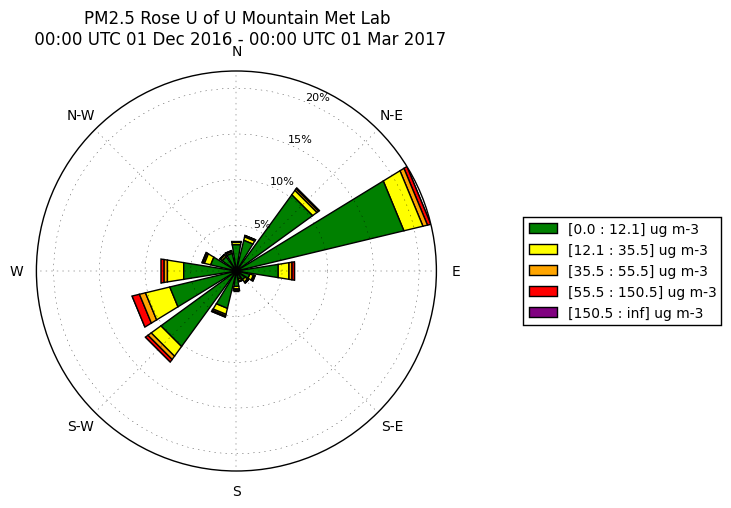

In [284]:
# Make the wind rose
ax = new_axes()
ax.bar(direction, PM25,
       nsector=16,
       normed=True,
       bins=[0, 12.1, 35.5, 55.5, 150.5],
       colors=('green', 'yellow', 'orange', 'red', 'purple'))

# Instead of ax.bar, try ax.contour, ax.contourf, ax.box
# What does ncestors do?
# How can you change the color range for each bin?
# How can you change the color of each bin?

# Create a legend
set_legend(ax)
plt.title("PM2.5 Rose %s \n %s - %s" % (a['NAME'], start.strftime('%H:%M UTC %d %b %Y'), end.strftime('%H:%M UTC %d %b %Y')))

plt.grid(True)

# Grid at 5% intervals
plt.yticks(np.arange(0, 105, 5))

# I don't want to label the 0%, so do this...
ax.set_yticklabels(['', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])

# Change the plot range
#ax.set_rmax(25)
ax.set_rmax(np.max(np.sum(ax._info['table'], axis=0)))

#### What does this data tell you?
- Do you know where MTMET station is? Get the latitude and longitude from the dictionary and find in Google maps
- Where do winds typically blow from?
- From what direction did we get the highest PM 25 pollution?

What data is used to make this plot?

In [285]:
# Values used to create the plot
print ax._info["table"]
print ""
print 'Total frequency in each direction:', np.sum(ax._info["table"],axis=0)
print 'Maximum freqency (what we set rmax to)', np.max(np.sum(ax._info["table"],axis=0))

[[  2.90401067   3.4534181   10.30923789  18.85644769   4.61502237
    1.49517306   1.14198258   0.87905188   1.69139      4.19904246
   10.20720509   7.49941135   5.83941606   2.89223766   1.91900165
    1.98571541]
 [  0.25900636   0.37673652   0.58472647   2.14268896   1.18907464
    0.40028255   0.32964445   0.21191429   0.27862805   0.66713759
    1.31072914   2.73918845   1.80127149   0.70245664   0.21583863
    0.18051958]
 [  0.06671376   0.14520053   0.20798995   0.51016404   0.33749313
    0.13735186   0.11773016   0.07848677   0.14127619   0.17659524
    0.43952594   0.67498626   0.3649635    0.16874657   0.08633545
    0.08633545]
 [  0.03924339   0.03139471   0.12950318   0.3845852    0.29040107
    0.08241111   0.0510164    0.04316773   0.05886508   0.14912487
    0.35711483   0.83195981   0.34926615   0.11380582   0.02747037
    0.04316773]
 [  0.           0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.  

In [286]:
print 'Why does it have this shape?', np.shape(ax._info["table"])
print 'Why is the last item all zeros?'

Why does it have this shape? (5L, 16L)
Why is the last item all zeros?


---------------------------

### Make plot with functions
Each of the plots are in functions.

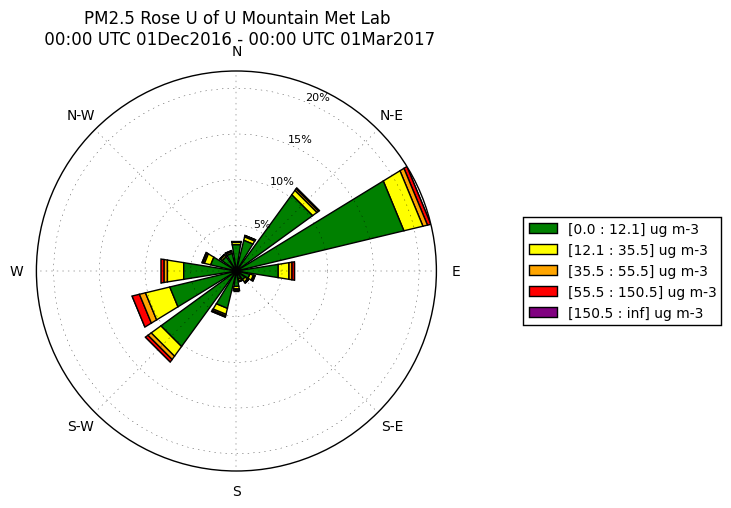

In [287]:
rose_with_labels()

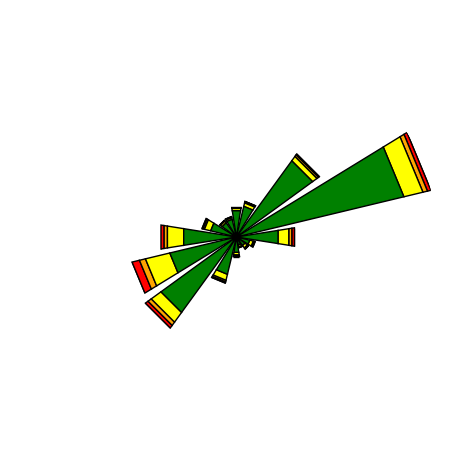

In [288]:
rose_no_labels()

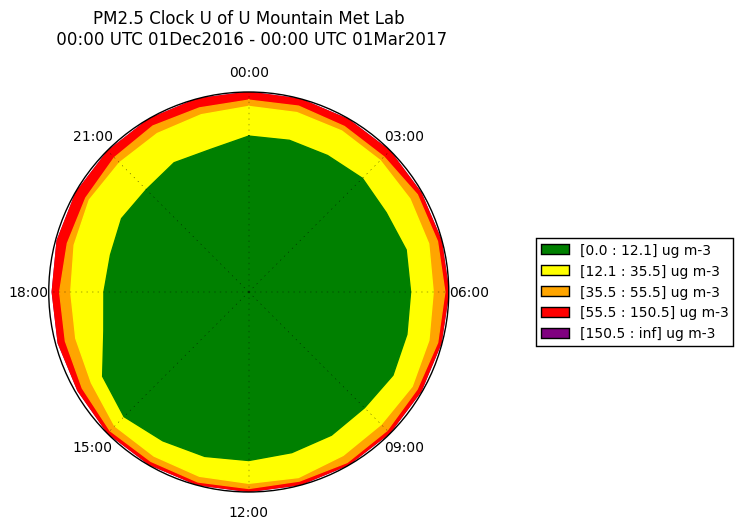

In [289]:
clock_rose()

----------------------

### How would you make a wind rose for antoher variable?

### What if we only want data when PM 25 was high?

In [295]:
high_PM_idx = a['PM_25_concentration'] > 35.5
# you'll get a warning becuase there may be nans in the data

C:\Users\blaylockbk\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


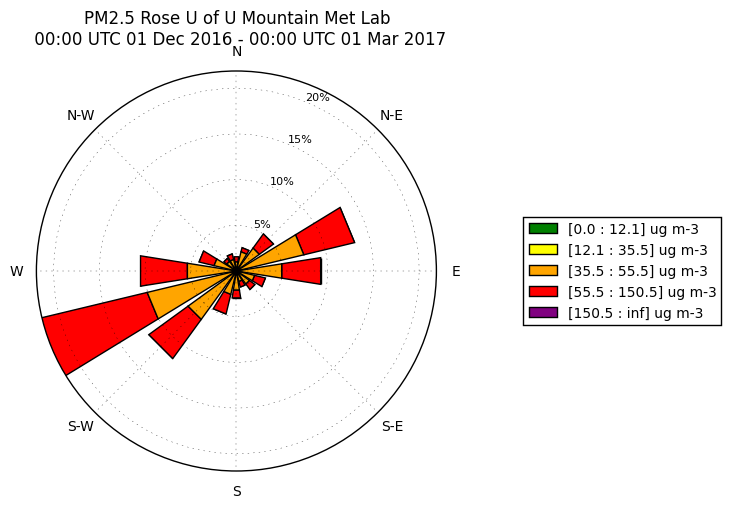

In [296]:
dir_high = a['wind_direction'][high_PM_idx]
PM25_high = a['PM_25_concentration'][high_PM_idx]

axH = new_axes()
axH.bar(dir_high, PM25_high,
            nsector=16,
            normed=True,
            bins=[0, 12.1, 35.5, 55.5, 150.5],
            colors=('green', 'yellow', 'orange', 'red', 'purple'))
# Create a legend
set_legend(ax)
plt.title("PM2.5 Rose %s \n %s - %s" % (a['NAME'], start.strftime('%H:%M UTC %d %b %Y'), end.strftime('%H:%M UTC %d %b %Y')))

plt.grid(True)

# Grid at 5% intervals
plt.yticks(np.arange(0, 105, 5))

# I don't want to label the 0%, so do this...
axH.set_yticklabels(['', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])

# Change the plot range
#axH.set_rmax(25)
axH.set_rmax(np.max(np.sum(ax._info['table'], axis=0)))